# Quick Start

IQM PulLA is a client-side software which allows the user to control the generation and execution of pulse-level instruction schedules on a quantum computer. Within the existing IQM QCCSW stack, PulLA is somewhere between circuit-level execution and EXA-experiment. Namely, with pulse-level access the user can:

- compile a quantum circuit (e.g. a Qiskit circuit) into an instruction schedule on the client side
- access and modify the calibration data to be used for the circuit-to-schedule compilation
- view and modify the default implementations of quantum gates
- define custom implementations of quantum gates
- define new composite gates out of native gates and set their calibration data
- control the multi-step compilation procedure, and edit the intermediate data
- use custom pulse shapes

This notebook contains a small meaningful example for a "quick start". Refer to other chapters for more details on various aspects of Pulla.

In [9]:
import os
from qiskit import QuantumCircuit, visualization
from qiskit.compiler import transpile
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import qiskit_to_pulla, station_control_result_to_qiskit

In [ ]:
# Create a Pulla object and a qiskit-iqm backend for accessing the quantum computer.
cocos_url = os.environ['PULLA_COCOS_URL']  # or set the URL directly here
station_control_url = os.environ['PULLA_STATION_CONTROL_URL']  # or set the URL directly here

p = Pulla(station_control_url)
provider = IQMProvider(cocos_url)
backend = provider.get_backend()

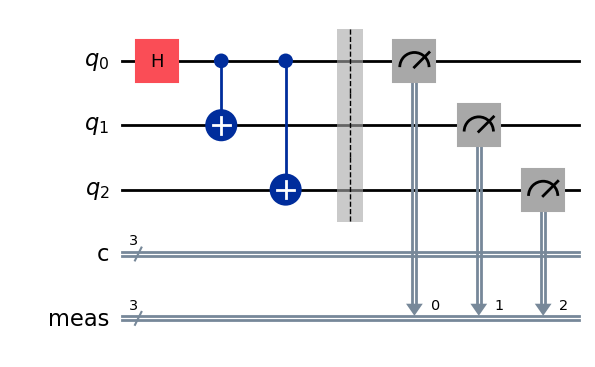

In [11]:
shots = 100

# Define a quantum circuit.
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()

qc.draw(output='mpl')

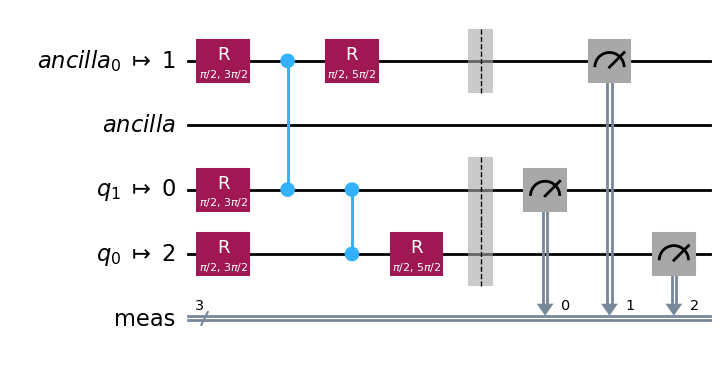

In [12]:
qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)
qc_optimized.draw(output="mpl")

[04-17 10:06:00;I] Submitted sweep with ID: 4ca23dc8-3302-4fe5-965c-14d283d1cc62
[04-17 10:06:00;I] Created task in queue with ID: 5908e9a9-77e2-40cb-9bd0-e0f934bd4528
[04-17 10:06:00;I] Sweep link: http://varda.qc.iqm.fi/station/sweeps/4ca23dc8-3302-4fe5-965c-14d283d1cc62
[04-17 10:06:00;I] Task link: http://varda.qc.iqm.fi/station/tasks/5908e9a9-77e2-40cb-9bd0-e0f934bd4528
[04-17 10:06:00;I] Waiting for the sweep to finish...
[04-17 10:06:00;I] Celery task ID: 5908e9a9-77e2-40cb-9bd0-e0f934bd4528
[04-17 10:06:02;I] Sweep status: SweepStatus.SUCCESS
Raw results:
[{'meas_3_1_2': [[1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

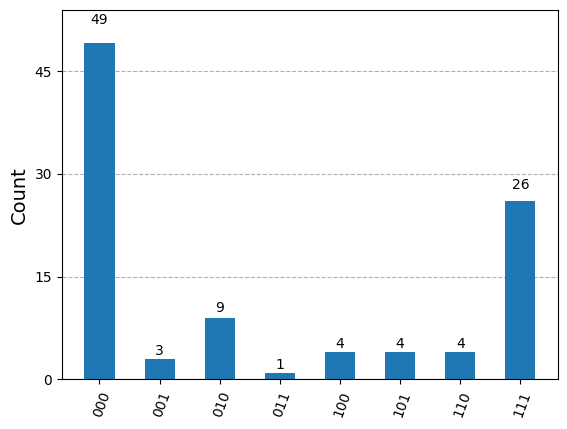

In [13]:
# Transpile the circuit using Qiskit, and then convert it into Pulla format.
qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)
circuits, compiler = qiskit_to_pulla(p, backend, qc_optimized)

# Compile the circuit into an instruction schedule playlist.
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=shots)

# Pulla.execute() returns a StationControlResult object; the measurements are in StationControlResult.result
# in addition, by default execute() prints the measurement results; disable it with verbose=False
response_data = p.execute(playlist, context, settings, verbose=False)
qiskit_result = station_control_result_to_qiskit(response_data, shots=shots, execution_options=context['options'])

print(f"Raw results:\n{response_data.result}\n")
print(f"Qiskit result counts:\n{qiskit_result.get_counts()}\n")
visualization.plot_histogram(qiskit_result.get_counts())

Executing the same circuit via CoCoS...
Qiskit result counts from CoCoS:
{'100': 12, '000': 45, '110': 6, '111': 16, '010': 7, '011': 4, '101': 8, '001': 2}


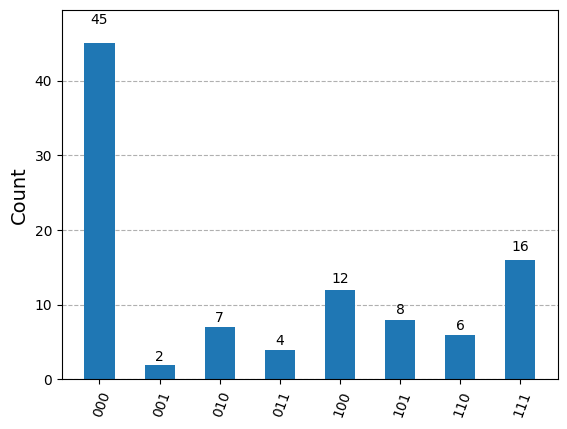

In [14]:
# The results should be comparable to a direct circuit execution through CoCoS.
print("Executing the same circuit via CoCoS...")
job = backend.run(qc_optimized, shots=shots)
print(f"Qiskit result counts from CoCoS:\n{job.result().get_counts()}")

visualization.plot_histogram(job.result().get_counts())

# Pulla Qiskit Backend

Pulla provides a Qiskit backend, with limited functionality. Its main purpose is to replace the normal execution of `run()`, which submits circuits to the remote server, with a local compilation and submission of pulse schedules to the remote server.

`IQMPullaBackend` does not provide any new functionality, but rather packs existing features and actions behind an illusion of using a normal Qiskit backend. You can perform all of the actions of `IQMPullaBackend` manually, but you may choose to use `IQMPullaBackend` in these cases:

- You don't need to control compilation, and want to use Pulla in the same way as a remote circuit-executing IQM Server uses it.
- You want to run some existing apps written for Qiskit, e.g. benchmarking tools; they often build on top ot the circuit abstraction, and don't necessarily give you easy access to the circuits, which makes it harder to use Pulla normally.
- You don't have access to a remote circuit-executing IQM Server, only to a pulse-executing IQM Server.
- You don't have any remote servers at all; all of the quantum control software is running locally (relevant for niche research cases)

To initialize an `IQMPullaBackend` instance, provide 3 arguments:

1. Quantum architecture in `QuantumArchitectureSpecification` format of IQM Client
2. Instance of `Pulla`
3. Instance of `Compiler`

When `IQMPullaBackend.run()` is called, the following steps are performed:

1. Given Qiskit circuits are converted to Pulla format using `qiskit_circuits_to_pulla()`.
2. Circuits are compiled with the provided compiler using `Compiler.compile()`.
3. Settings are generated with the provided compiler using `Compiler.build_settings()`.
4. Circuits are executed on the station associated with the provided `Pulla` instance.
5. Results are retrieved and converted into a `DummyJob`, partially compatible with Qiskit `Job`.

Working example below:

[04-17 10:07:08;I] Submitted sweep with ID: 95370d5a-f27f-4269-80a0-6a7108ebd387
[04-17 10:07:08;I] Created task in queue with ID: 057662b7-d621-460c-88ad-74efbd193bdb
[04-17 10:07:08;I] Sweep link: http://varda.qc.iqm.fi/station/sweeps/95370d5a-f27f-4269-80a0-6a7108ebd387
[04-17 10:07:08;I] Task link: http://varda.qc.iqm.fi/station/tasks/057662b7-d621-460c-88ad-74efbd193bdb
[04-17 10:07:08;I] Waiting for the sweep to finish...
[04-17 10:07:09;I] Celery task ID: 057662b7-d621-460c-88ad-74efbd193bdb
[04-17 10:07:12;I] Sweep status: SweepStatus.SUCCESS


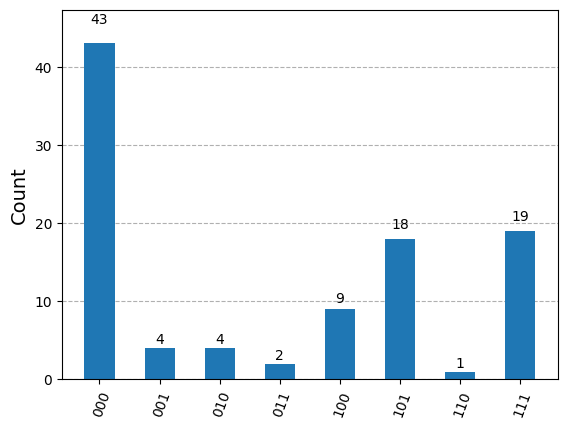

In [16]:
from iqm.pulla.utils_qiskit import IQMPullaBackend
from iqm.iqm_client import IQMClient, DynamicQuantumArchitecture

client = IQMClient(cocos_url)
architecture: DynamicQuantumArchitecture = client.get_dynamic_quantum_architecture()

compiler = p.get_standard_compiler()
backend = IQMPullaBackend(architecture, p, compiler)

qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)

job = backend.run(qc_optimized, shots=shots)

visualization.plot_histogram(job.result().get_counts())

## Authentication

If the remote station requires authentication:

1. Install IQM Client CLI with **`pip install iqm-client[cli]`**
2. Run **`iqmclient init`**. The wizard will start and ask questions. Accepting defaults is ok.
3. Wizard will ask for `Authentication server URL`. Usually, it's of the form `https://STATION_ROOT/auth`. E.g. if the Station Control URL is `"https://abc.com/station/"`, then the auth server URL is `"https://abc.com/auth/"`
4. Run **`iqmclient auth login`**. You should see info like so:
    ```
    To use the tokens file with IQM Client or IQM Client-based software, set the environment variable:

    export IQM_TOKENS_FILE=/home/user/.cache/iqm-client-cli/tokens.json
    ```
5. Set the environment variable `IQM_TOKENS_FILE` accordingly in your Jupyter notebook and pass `get_token_callback` to the Pulla initialization call like so:

    ```python
    import os
    from iqm.iqm_client.authentication import TokenManager

    os.environ["IQM_TOKENS_FILE"]="/home/user/.cache/iqm-client-cli/tokens.json"

    p = Pulla(
        station_control_url=station_control_url, 
        get_token_callback=TokenManager().get_bearer_token,
    )
    ```

Setting `IQM_TOKENS_FILE` env. variable enables authentication for CoCoS as well, so your Qiskit runs against the same station will work, too.

# Using Pulla with IQM Resonance

Pulla can also be used with [IQM Resonance](https://www.meetiqm.com/products/iqm-resonance) cloud service. You need to set the station URL to point to Resonance. In addition to that, you must provide a `get_token_callback` parameter function that returns your Resonance API token.


In [11]:
# This cocos URL can be found from the Resonance dashboard device card.
# For example: https://cocos.resonance.meetiqm.com/garnet 
quantum_computer_url = os.environ.get("RESONANCE_QUANTUM_COMPUTER_URL") 
api_token = os.environ.get("RESONANCE_API_TOKEN")

p = Pulla(quantum_computer_url, get_token_callback=lambda: api_token)
provider = IQMProvider(quantum_computer_url, token=api_token)
backend = provider.get_backend()

# From now on, the usage is same as for direct station control usage 
# qc = ...

qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)
circuits, compiler = qiskit_to_pulla(p, backend, qc_optimized)
pl, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=shots)

# Pulla.execute() returns a StationControlResult object; the measurements are in StationControlResult.result
# in addition, by default execute() prints the measurement results; disable it with verbose=False
response_data = p.execute(pl, context, settings, verbose=False)
qiskit_result = station_control_result_to_qiskit(response_data, shots=shots, execution_options=context['options'])

print(f"Qiskit result counts:\n{qiskit_result.get_counts()}\n")

[04-02 15:52:50;I] Submitted sweep with ID: 0195f68f-bd5e-7731-abf8-bb48bd615be8
[04-02 15:52:50;I] Created task in queue with ID: 0195f68f-bd5e-7731-abf8-bb48bd615be8
[04-02 15:52:50;I] Waiting for the sweep to finish...


[04-02 15:53:01;I] Sweep status: SweepStatus.SUCCESS
Qiskit result counts:
{'111': 21, '100': 20, '000': 33, '011': 26}



# Schedule visualization

IQM Pulse comes with a schedule visualizer. It takes a Playlist (i.e. a compressed list of instruction schedules) and a list of schedule/segment indices to inspect. 
The `playlist` variable below is the one which we derived from the original Qiskit circuit using the Pulla compiler, and it only has one schedule.

In [18]:
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML

HTML(inspect_playlist(playlist, [0]))